# Model Development

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

In [2]:
full_df = pd.read_csv('processed_data.csv')

In [3]:
full_df

,ACTOR,ROLE,TITLE,AWARD,SCORE_1,SCORE_2,NUM_REVIEWS,polarity_mean,objectivity_mean,NUMERIC_KEY
0,Adam Driver,charlie barber,marriage story,1.0,85.0,94.0,48.0,0.190969,0.479507,0
1,Adolphe Menjou,walter burns,the front page,1.0,60.0,93.0,1.0,0.500000,1.000000,1
2,Adrien Brody,wladyslaw szpilman,the pianist,2.0,96.0,95.0,40.0,0.128576,0.603966,2
3,Al Pacino,frank serpico,serpico,1.0,88.0,90.0,6.0,0.238542,0.572917,3
4,Al Pacino,michael corleone,the godfather part ii,1.0,97.0,98.0,17.0,0.380286,0.646926,3
...,...,...,...,...,...,...,...,...,...,...
14469,Max von Sydow,director,rosamunde pilchner two sisters,0.0,0.0,0.0,0.0,0.000000,0.000000,141
14470,Max von Sydow,narrator,europa,0.0,89.0,80.0,2.0,0.500000,0.562500,141
14471,Max von Sydow,director,katinka,0.0,0.0,0.0,0.0,0.000000,0.000000,141
14472,Ralph Fiennes,narrator,andre the voice of wine,0.0,0.0,0.0,0.0,0.000000,0.000000,169


In [4]:
exclude_roles = ['director','producer','executive producer','narrator','host','writer','original music', 'music','screenwriter']
for role in exclude_roles:
    full_df = full_df[full_df.ROLE != role]

In [5]:
full_df

,ACTOR,ROLE,TITLE,AWARD,SCORE_1,SCORE_2,NUM_REVIEWS,polarity_mean,objectivity_mean,NUMERIC_KEY
0,Adam Driver,charlie barber,marriage story,1.0,85.0,94.0,48.0,0.190969,0.479507,0
1,Adolphe Menjou,walter burns,the front page,1.0,60.0,93.0,1.0,0.500000,1.000000,1
2,Adrien Brody,wladyslaw szpilman,the pianist,2.0,96.0,95.0,40.0,0.128576,0.603966,2
3,Al Pacino,frank serpico,serpico,1.0,88.0,90.0,6.0,0.238542,0.572917,3
4,Al Pacino,michael corleone,the godfather part ii,1.0,97.0,98.0,17.0,0.380286,0.646926,3
...,...,...,...,...,...,...,...,...,...,...
13911,Terrence Howard,jimmy,best laid plans,0.0,38.0,43.0,5.0,1.000000,0.300000,206
13912,Terrence Howard,dexter banks,butter,0.0,0.0,0.0,0.0,0.000000,0.000000,206
13913,Terrence Howard,jimmy the warlock,johns,0.0,58.0,54.0,2.0,-0.107143,0.517857,206
13914,Terrence Howard,spaceman,sunset park,0.0,83.0,13.0,3.0,0.336111,0.491667,206


## Visual Inspection:
    A brief look into a correlation matrix for the data set shows that there are strong a moderate not-neccessarily linear correlations. All of which suggests further investigation.

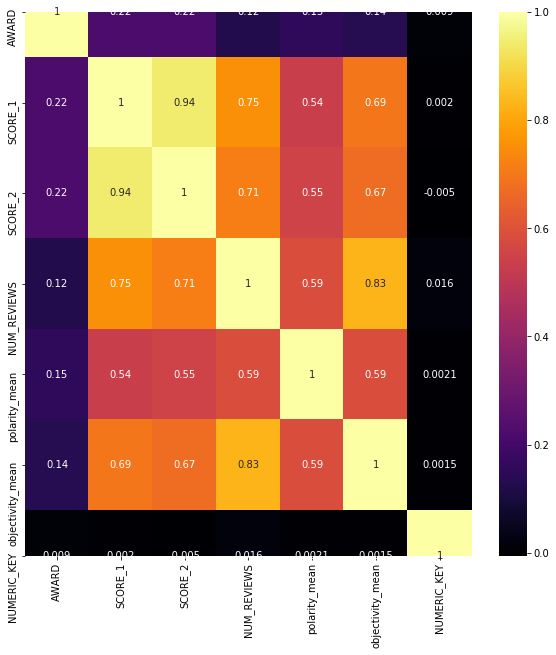

In [6]:
plt.figure(figsize=(10,10))
c = full_df.corr(method='spearman')
sns.heatmap(c,cmap='inferno',annot=True)

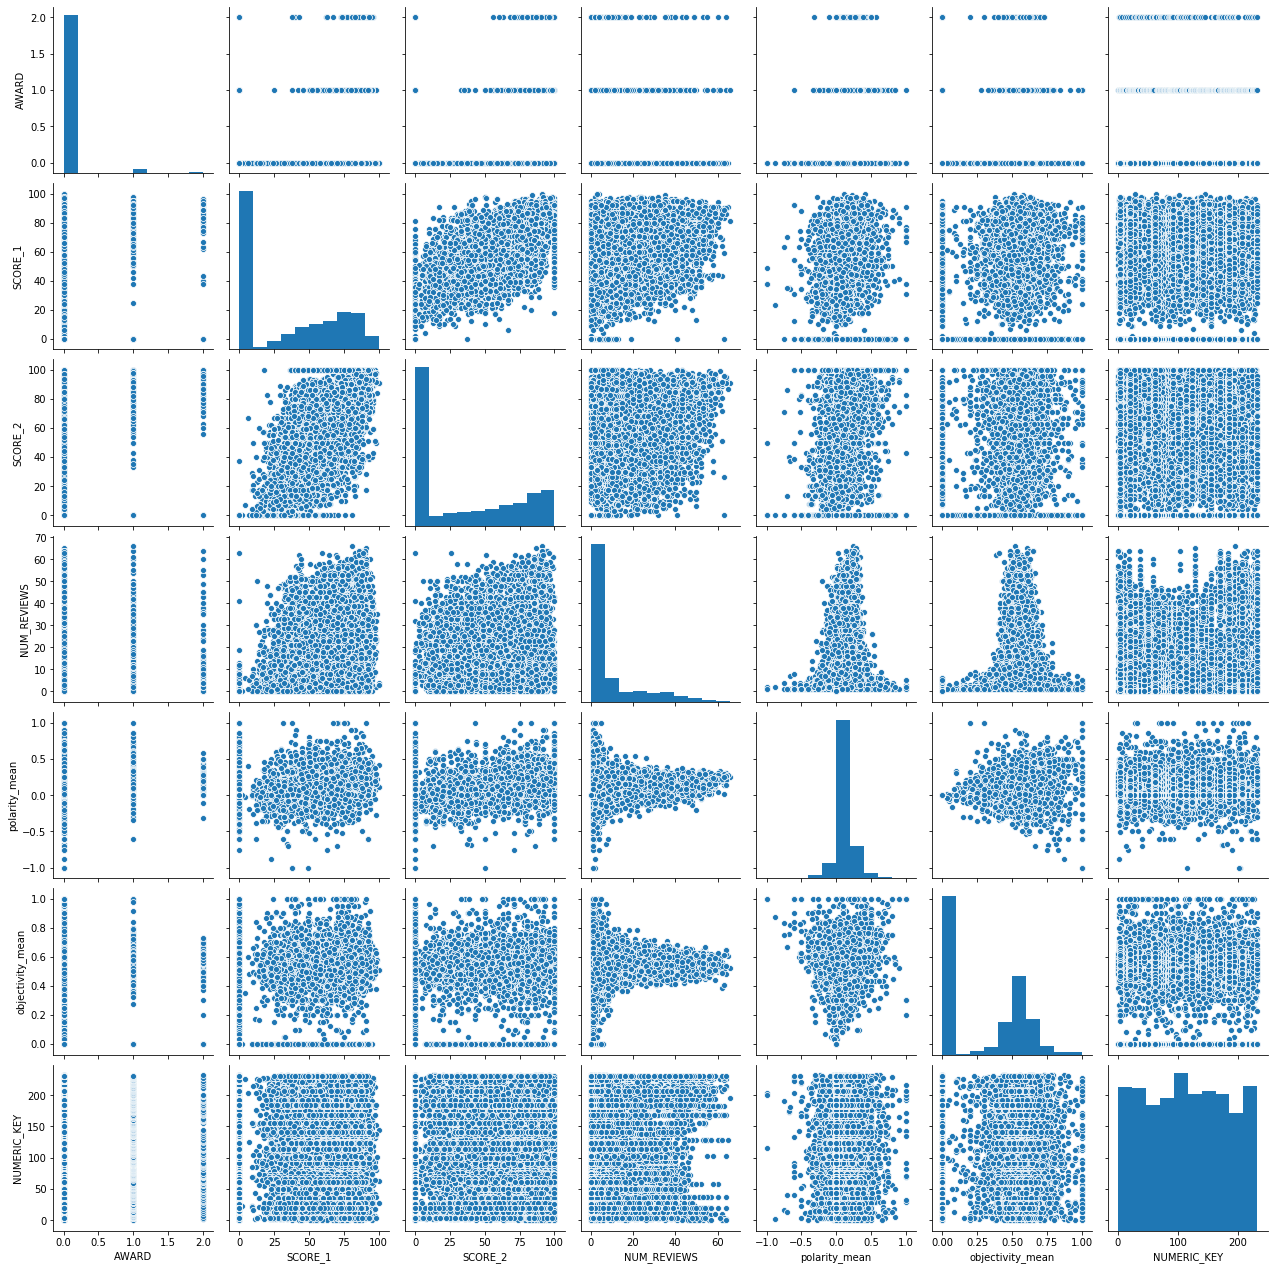

In [7]:
sns.pairplot(data=full_df)

## Iteratively Developing model:

    Due to the highly imbalanced nature of the data an iterative gridsearch with appropriate weighting is used to determine the best parameters for the model. Periodic recalibration is done to ensure the optimal number of trees are constructed.

In [8]:
def balancedWeights(label_set):
    classes = label_set.unique()
    classes.sort()
    class_weights = list(class_weight.compute_class_weight('balanced',
                                                           np.unique(label_set),
                                                           label_set.values))
    
    cw_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
    cw_array = [cw_dict[i] for i in label_set.values]
    return cw_array

def modelFit(alg, X, y, useTrainCV=True, cvFolds=5, esr = 50):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=121)
    
    whole_set_wt = balancedWeights(y)
    train_set_wt = balancedWeights(y_train)
    
    if useTrainCV:
        xgbParams = alg.get_xgb_params()
        xgTrain = xgb.DMatrix(X, label=y.values, weight=whole_set_wt)
        cvresult = xgb.cv(xgbParams, xgTrain,
                          num_boost_round=alg.get_params()['n_estimators'], nfold=cvFolds,
                          metrics={'mlogloss'},early_stopping_rounds=esr)

        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm
    alg.fit(X_train, y_train, eval_metric='mlogloss', sample_weight=train_set_wt)

    # Predict
    train_preds = alg.predict(X_train)
    train_prob = alg.predict_proba(X_train)
    
    test_preds = alg.predict(X_test)
    test_prob = alg.predict_proba(X_test)

    # Print model report:
    print("\nModel Report")
    print( "Accuracy (Train): {:.2%}".format(metrics.accuracy_score(y_train, train_preds)))
    print("Log Loss Score (Train): {:.2%}".format(metrics.log_loss(y_train, train_prob)))
    print( "Accuracy (Test): {:.2%}".format(metrics.accuracy_score(y_test, test_preds)))
    print("Log Loss Score (Train): {:.2%}".format(metrics.log_loss(y_test, test_prob)))


In [9]:
X = full_df[['SCORE_1','SCORE_2','NUM_REVIEWS','polarity_mean','objectivity_mean','NUMERIC_KEY']]
y = full_df['AWARD']
y_weights = balancedWeights(y)

Pass classes=[0. 1. 2.], y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [10]:
base_model = xgb.XGBClassifier(learning_rate= 0.1, n_estimators=1000,
                              max_depth=5, min_child_weight=1,
                              gamma=0, alpha=1,
                              colsample_bytree=0.8,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)

modelFit(base_model, X, y)

Pass classes=[0. 1. 2.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0              1.049383            0.001437            1.065182   
1              1.005610            0.003354            1.042050   
2              0.964461            0.006010            1.017829   
3              0.926344            0.007618            0.998228   
4              0.892417            0.008357            0.983039   
5              0.861806            0.009520            0.968862   
6              0.834067            0.010758            0.955694   
7              0.810068            0.012443            0.947576   
8              0.786347            0.012809            0.938174   
9              0.765341            0.012225            0.931478   
10             0.746112            0.012220            0.926452   
11             0.728242            0.012894            0.922603   
12             0.709784            0.012508            0.921550   
13             0.695110            0.011697            0.92024

In [11]:
param_search1 = {
    'min_child_weight': range(1,6,2),
    'max_depth': range(3,10,2)
}

xgb_clf1 = xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=16,
                             gamma=0, alpha=1,
                              colsample_bytree=0.8,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)

grid_search1 = GridSearchCV(xgb_clf1, param_search1,
                             scoring='neg_log_loss', n_jobs=4,
                             cv=12)
grid_search1.fit(X,y, sample_weight = y_weights)

GridSearchCV(cv=12,
             estimator=XGBClassifier(alpha=1, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=16, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, s

In [12]:
print('\n All results:')
print(grid_search1.cv_results_)
print('\n Best estimator:')
print(grid_search1.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search1.best_params_)


 All results:
{'mean_fit_time': array([ 9.86215913,  9.99158885, 10.27622191, 17.61080348, 17.36217733,
       16.58466641, 25.0216039 , 25.00985012, 25.45821075, 33.97841012,
       33.01128163, 32.43264246]), 'std_fit_time': array([0.76291479, 0.537986  , 0.34539361, 0.63329773, 0.57344431,
       2.54273568, 1.15901908, 1.0403416 , 0.47524162, 0.9337567 ,
       0.96211733, 2.19094009]), 'mean_score_time': array([0.03353709, 0.03437771, 0.0325795 , 0.03274419, 0.03345031,
       0.03479834, 0.03435316, 0.0332494 , 0.03873044, 0.03563909,
       0.03403918, 0.0300764 ]), 'std_score_time': array([0.00610824, 0.00507944, 0.00873314, 0.00538685, 0.00685214,
       0.00759096, 0.00832935, 0.00727925, 0.00582671, 0.00637803,
       0.00504953, 0.01224997]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            d

In [13]:
param_search2 = {
    'min_child_weight': [.5,1,1.5,2],
    'max_depth' : [8,9,10]
    
}

xgb_clf2 = xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=16, 
                             gamma=0, alpha=1,
                              colsample_bytree=0.8,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
grid_search2 = GridSearchCV(xgb_clf2, param_search2,
                           scoring='neg_log_loss',n_jobs=4,
                           cv=12)
grid_search2.fit(X,y, sample_weight = y_weights)

GridSearchCV(cv=12,
             estimator=XGBClassifier(alpha=1, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=16, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, s

In [14]:
print('\n All results:')
print(grid_search2.cv_results_)
print('\n Best estimator:')
print(grid_search2.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search2.best_params_)


 All results:
{'mean_fit_time': array([29.22856218, 28.68022096, 28.68381004, 30.46062917, 34.43274254,
       32.56360414, 32.53469723, 33.35878803, 37.1536443 , 36.37196853,
       36.90381054, 34.92515582]), 'std_fit_time': array([1.83499754, 1.48384765, 1.67044239, 1.26772865, 0.8980807 ,
       2.12243755, 1.36031395, 0.88858787, 1.58654517, 1.78498741,
       1.77820002, 5.16840338]), 'mean_score_time': array([0.03910927, 0.03640141, 0.03885772, 0.03831061, 0.03540836,
       0.03718227, 0.03226294, 0.0375693 , 0.03482854, 0.03499496,
       0.03603592, 0.03134944]), 'std_score_time': array([0.01304938, 0.00614161, 0.00781354, 0.01347346, 0.0063213 ,
       0.00891025, 0.00915356, 0.00640095, 0.00532032, 0.00446055,
       0.00483478, 0.01073047]), 'param_max_depth': masked_array(data=[8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
         

In [15]:
param_search3 = {'gamma' : [i/10.0 for i in range(0,5)]}

xgb_clf3 =  xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=16,
                             max_depth=10, min_child_weight = 1,
                              alpha=1, colsample_bytree=0.8,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
grid_search3 = GridSearchCV(xgb_clf3, param_search3,
                            scoring='neg_log_loss',
                            n_jobs=4,cv=12)
grid_search3.fit(X,y, sample_weight = y_weights)

GridSearchCV(cv=12,
             estimator=XGBClassifier(alpha=1, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=16, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, sca

In [16]:
print('\n All results:')
print(grid_search3.cv_results_)
print('\n Best estimator:')
print(grid_search3.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search3.best_params_)


 All results:
{'mean_fit_time': array([37.79236708, 38.17883084, 37.85025525, 37.48691261, 33.68442438]), 'std_fit_time': array([1.90965439, 1.00295335, 1.49579371, 1.07740276, 5.85206972]), 'mean_score_time': array([0.03819712, 0.03465327, 0.03820036, 0.03551986, 0.02908188]), 'std_score_time': array([0.00714447, 0.00819383, 0.00601172, 0.00558044, 0.01011907]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}], 'split0_test_score': array([-0.51938798, -0.51917344, -0.52337346, -0.52320756, -0.52028968]), 'split1_test_score': array([-0.56524363, -0.56524619, -0.56558473, -0.56548898, -0.56398916]), 'split2_test_score': array([-0.54783876, -0.54742463, -0.54849968, -0.54854275, -0.5495839 ]), 'split3_test_score': array([-0.5400194 , -0.53950959, -0.53875352, -0.53816057, -0.54063145

In [17]:
partial_model = xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=1000, gamma=0,
                             max_depth=10, min_child_weight = 1,
                              alpha=1, colsample_bytree=0.8,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
modelFit(partial_model, X, y)

Pass classes=[0. 1. 2.], y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass classes=[0. 1. 2.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


   train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0             1.013608            0.005894            1.066743   
1             0.936597            0.004667            1.046132   
2             0.868238            0.009687            1.025274   
3             0.803298            0.012111            1.010157   
4             0.750416            0.012449            0.997774   
5             0.699902            0.011141            0.989707   
6             0.655993            0.014168            0.983904   
7             0.617696            0.014465            0.980806   
8             0.580818            0.014632            0.976289   
9             0.548611            0.014016            0.974145   

   test-mlogloss-std  
0           0.006218  
1           0.013396  
2           0.017172  
3           0.021273  
4           0.018956  
5           0.022597  
6           0.024619  
7           0.029312  
8           0.030090  
9           0.026736  

Model Report
Accura

In [18]:
param_search4 = {'subsample': [i/10.0 for i in range(6,10)],
                'colsample_bytree': [i/10.0 for i in range(6,10)]}

xgb_clf4 = xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=10, gamma=0,
                             max_depth=10, min_child_weight = 1,
                             alpha = 1,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
grid_search4 = GridSearchCV(xgb_clf4, param_search4,
                            scoring='neg_log_loss',
                            n_jobs=4,cv=12)
grid_search4.fit(X,y, sample_weight = y_weights)

GridSearchCV(cv=12,
             estimator=XGBClassifier(alpha=1, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=10, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale

In [19]:
print('\n All results:')
print(grid_search4.cv_results_)
print('\n Best estimator:')
print(grid_search4.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search4.best_params_)


 All results:
{'mean_fit_time': array([21.06700377, 20.24256837, 21.27033097, 20.7114807 , 23.1402747 ,
       22.7126177 , 23.86879883, 22.86372366, 22.97825257, 22.68022672,
       22.8465397 , 23.30873746, 24.84560515, 24.67586136, 24.57316252,
       24.68473276]), 'std_fit_time': array([0.94602835, 1.22631401, 0.81691664, 1.29458434, 1.3462408 ,
       1.1346952 , 0.59806671, 1.16687602, 0.70199541, 0.90879937,
       1.56649873, 1.4361019 , 0.59615957, 1.08528931, 1.26874852,
       1.78153995]), 'mean_score_time': array([0.0352026 , 0.03171074, 0.03369633, 0.02991549, 0.03512621,
       0.03306758, 0.03239848, 0.033125  , 0.03346513, 0.03215647,
       0.03420273, 0.03424696, 0.03044339, 0.03732727, 0.03339289,
       0.02784232]), 'std_score_time': array([0.00773518, 0.00430485, 0.00356603, 0.00461717, 0.00646583,
       0.00492776, 0.00531629, 0.00667301, 0.00803173, 0.0115213 ,
       0.00671371, 0.004729  , 0.00385512, 0.00572265, 0.00491291,
       0.00993529]), 'param_col

In [20]:
param_search5 = {'alpha': [1e-5,1e-2,0.1,1,10,100]}

xgb_clf5 = xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=9, gamma=0,
                             max_depth=10, min_child_weight = 1,
                             alpha = 1, colsample_bytree=0.9,
                              subsample = 0.6, max_delta_step = 0,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
grid_search5 = GridSearchCV(xgb_clf5, param_search5,
                            scoring='neg_log_loss',
                            n_jobs=4,cv=12)
grid_search5.fit(X,y,sample_weight = y_weights)

GridSearchCV(cv=12,
             estimator=XGBClassifier(alpha=1, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=9, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_

In [21]:
print('\n All results:')
print(grid_search5.cv_results_)
print('\n Best estimator:')
print(grid_search5.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search5.best_params_)


 All results:
{'mean_fit_time': array([22.52227241, 22.43507459, 22.57064235, 22.07450507, 20.75849372,
       12.05990307]), 'std_fit_time': array([0.63819778, 1.10128088, 0.84465621, 1.02630585, 0.96572019,
       1.94084256]), 'mean_score_time': array([0.03013819, 0.03372421, 0.03377841, 0.0331314 , 0.03360407,
       0.02671971]), 'std_score_time': array([0.00706896, 0.01096486, 0.0068867 , 0.00634726, 0.00675997,
       0.00816069]), 'param_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 10, 100],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 1e-05}, {'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}, {'alpha': 100}], 'split0_test_score': array([-0.60812918, -0.6082517 , -0.61227316, -0.6257831 , -0.69504681,
       -0.77513088]), 'split1_test_score': array([-0.63829961, -0.63916244, -0.64000047, -0.65956863, -0.68381913,
       -0.75971427]), 'split2_test_score': array([-0.63338899, 

In [22]:
param_search6 = {'alpha':[0.005, 0.01, 0.15, 0.2]}

xgb_clf6 = xgb.XGBClassifier(learning_rate = 0.1,
                             n_estimators=9, gamma=0,
                             max_depth=10, min_child_weight = 1,
                             alpha = 1, colsample_bytree=0.9,
                              subsample = 0.6, max_delta_step = 0,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
grid_search6 = GridSearchCV(xgb_clf6, param_search6,
                            scoring='neg_log_loss',
                            n_jobs=4,cv=12)
grid_search6.fit(X,y,sample_weight = y_weights)

GridSearchCV(cv=12,
             estimator=XGBClassifier(alpha=1, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=9, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_

In [23]:
print('\n All results:')
print(grid_search6.cv_results_)
print('\n Best estimator:')
print(grid_search6.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search6.best_params_)


 All results:
{'mean_fit_time': array([21.35335815, 22.67725571, 22.57650554, 20.97668858]), 'std_fit_time': array([1.27908067, 0.67999068, 0.88058502, 1.55097219]), 'mean_score_time': array([0.03491175, 0.03105189, 0.03322625, 0.02688249]), 'std_score_time': array([0.00683241, 0.0041103 , 0.00700574, 0.01117228]), 'param_alpha': masked_array(data=[0.005, 0.01, 0.15, 0.2],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.005}, {'alpha': 0.01}, {'alpha': 0.15}, {'alpha': 0.2}], 'split0_test_score': array([-0.60819038, -0.6082517 , -0.61142303, -0.61299382]), 'split1_test_score': array([-0.63843686, -0.63916244, -0.64363405, -0.64408562]), 'split2_test_score': array([-0.63277453, -0.63251551, -0.63679166, -0.63808177]), 'split3_test_score': array([-0.61888189, -0.6189572 , -0.62189725, -0.62195436]), 'split4_test_score': array([-0.62710694, -0.62716944, -0.62947911, -0.6308648 ]), 'split5_test_score': array([-0.6016

In [48]:
tuned_model = xgb.XGBClassifier(learning_rate = 0.01,
                             n_estimators=1000, gamma=0,
                             max_depth=10, min_child_weight = 1,
                             alpha = 0.01, colsample_bytree=0.9,
                              subsample = 0.6, max_delta_step = 0,
                              objective='multi:softmax', num_class=3,
                              nthread=4,seed=121)
modelFit(tuned_model, X, y)

Pass classes=[0. 1. 2.], y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
Pass classes=[0. 1. 2.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0              1.090588            0.000441            1.095892   
1              1.083026            0.000652            1.093266   
2              1.075565            0.000652            1.090546   
3              1.068153            0.000758            1.087464   
4              1.061122            0.000969            1.085151   
..                  ...                 ...                 ...   
80             0.677988            0.005984            0.997217   
81             0.674567            0.005959            0.997385   
82             0.671225            0.005874            0.997211   
83             0.667883            0.005970            0.996790   
84             0.664553            0.006088            0.996603   

    test-mlogloss-std  
0            0.000695  
1            0.001178  
2            0.001673  
3            0.001805  
4            0.002115  
..                ...  
80           0.017032  
81 

    The final model has improved Accuracy on both the training and test sets used to train the model. With okay certainty on the probability that the predicted values are true.

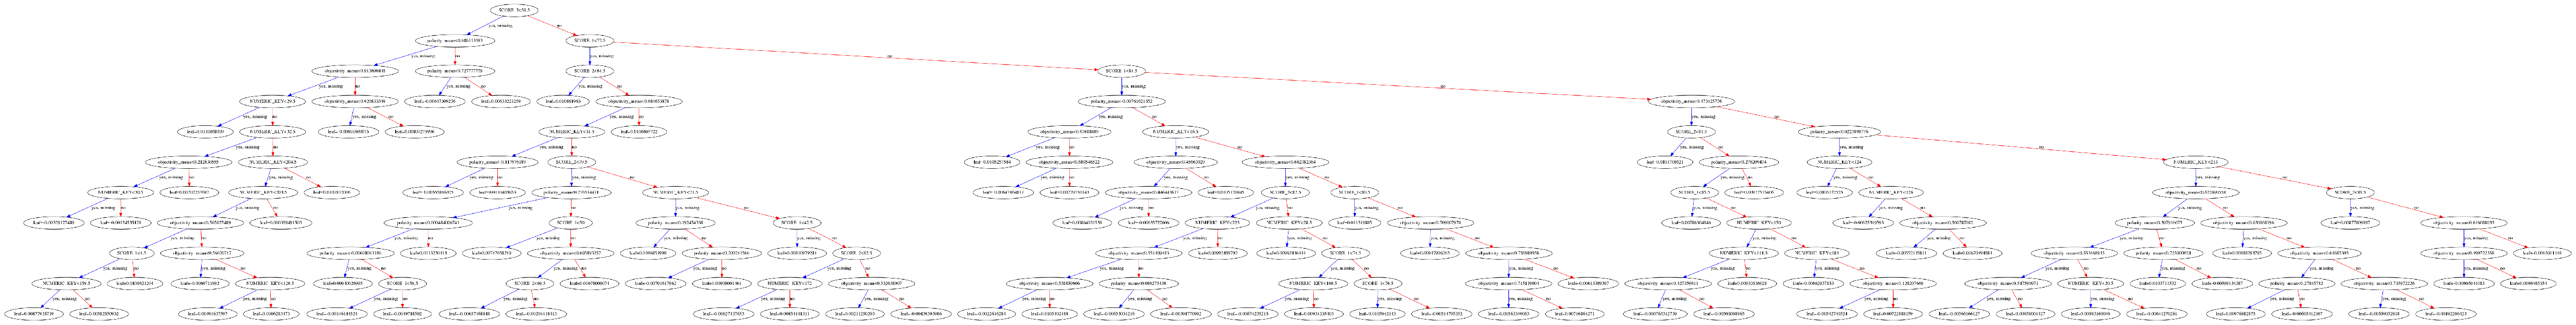

In [25]:
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(tuned_model, num_trees=84, ax = ax)
plt.show()

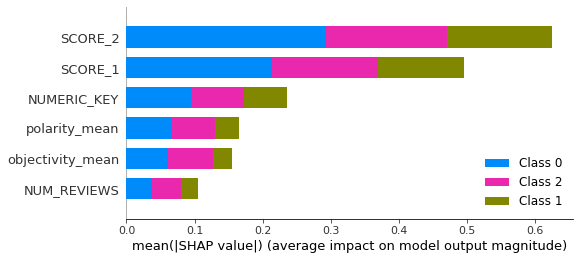

In [26]:
shap_explainer = shap.TreeExplainer(tuned_model)
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

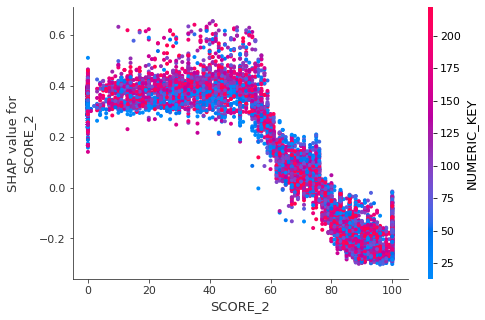

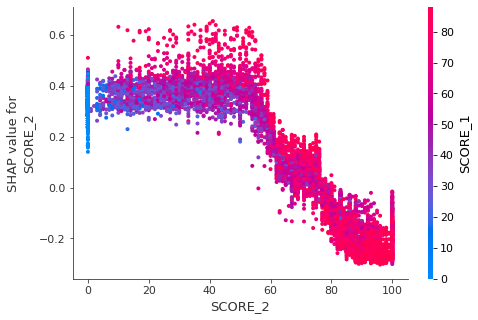

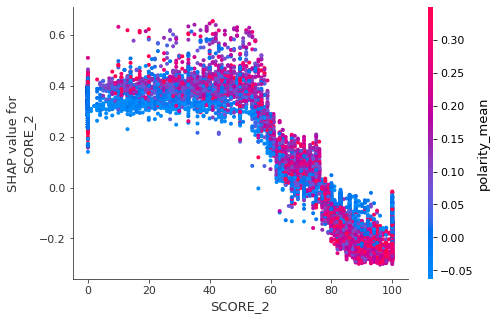

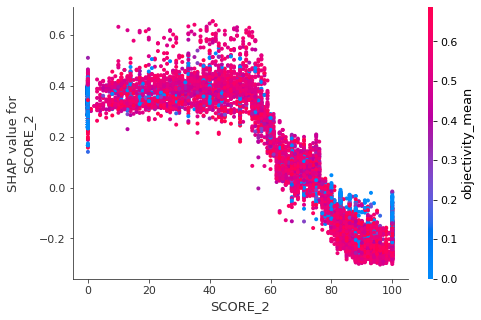

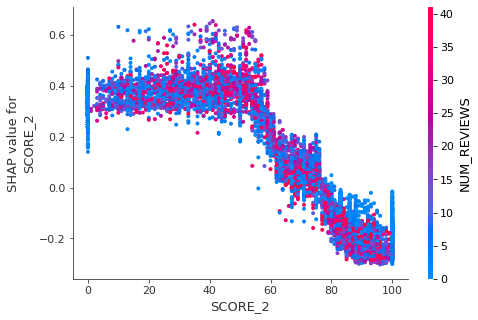

In [27]:
inds = shap.approximate_interactions("SCORE_2", shap_values[0],X)
for i in range(5):
    shap.dependence_plot("SCORE_2", shap_values[0], X, interaction_index=inds[i])

    SHAP shows that the feature that has the greatest impact on the model is SCORE_2 which is a composite user generated score. The feature with the second highest importance is SCORE_1 which is analogous to a meta critic rating. Then the numeric key corresponding to the individual actor, then polarity, objectivity, and finally the number of reviews. We further see how every other feature interacts with SCORE_2 in influencing the model.

In [49]:
non_leo = full_df[full_df['ACTOR'] != 'Leonardo DiCaprio']
leo_set = full_df[full_df['ACTOR'] == 'Leonardo DiCaprio']

X_train_non, y_train_non = non_leo[['SCORE_1','SCORE_2','NUM_REVIEWS','polarity_mean','objectivity_mean','NUMERIC_KEY']], non_leo['AWARD']
X_test_leo, y_test_leo = leo_set[['SCORE_1','SCORE_2','NUM_REVIEWS','polarity_mean','objectivity_mean','NUMERIC_KEY']], leo_set['AWARD']

non_leo_wt = balancedWeights(y_train_non)

Pass classes=[0. 1. 2.], y=[1. 1. 2. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error


### Prediction:
    Here a random selection of data was used to train the model, where it is possible that some of DiCaprio's information is used to train the model, and it is then tested with his entire filmography as an actor.

In [50]:
leo_preds_1 = tuned_model.predict(X_test_leo)
leo_proba_1 = tuned_model.predict_proba(X_test_leo)
print('Prediction accuracy: {:.2%}'.format(metrics.accuracy_score(y_test_leo,leo_preds_1)))
print('Prediction Log Loss: {:.2%}'.format(metrics.log_loss(y_test_leo,leo_proba_1)))
leo_useful = leo_set[['ROLE','TITLE','AWARD']]
leo_useful.reset_index(drop=True,inplace=True)
leo_pred_df = pd.DataFrame({'PRED':leo_preds_1})
leo_pred_df.reset_index(drop=True, inplace=True)
leo_comparison = pd.concat([leo_useful, leo_pred_df],axis=1)
leo_comparison

Prediction accuracy: 74.19%
Prediction Log Loss: 76.58%


,ROLE,TITLE,AWARD,PRED
0,howard hughes,the aviator,1.0,1.0
1,danny archer,blood diamond,1.0,1.0
2,jordan belfort,the wolf of wall street,1.0,0.0
3,hugh glass,the revenant,2.0,0.0
4,rick dalton,once upon a time in hollywood,1.0,1.0
5,himself,spielberg,0.0,1.0
6,unknown,before the flood trailer,0.0,0.0
7,himself,before the flood,0.0,0.0
8,jay gatsby,the great gatsby,0.0,0.0
9,calvin candie,django unchained,0.0,0.0


### Prediction:
    Here we retrain the model where the only information that is held out is DiCaprio's filmography as an actor. The model is retrained using the rest of the information with the correct weighting for the target values.

In [51]:
tuned_model.fit(X_train_non, y_train_non, sample_weight=non_leo_wt)

XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=85, n_jobs=4, nthread=4, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', random_state=121,
              reg_alpha=0.00999999978, reg_lambda=1, scale_pos_weight=None,
              seed=121, subsample=0.6, tree_method='exact',
              validate_parameters=1, ...)

In [57]:
leo_preds_2 = tuned_model.predict(X_test_leo)
leo_proba_2 = tuned_model.predict_proba(X_test_leo)
print('Prediction accuracy: {:.2%}'.format(metrics.accuracy_score(y_test_leo,leo_preds_2)))
print('Prediction recall: {:.2%}'.format(metrics.log_loss(y_test_leo,leo_proba_2)))
leo_useful2 = leo_set[['ROLE','TITLE','AWARD']]
leo_useful2.reset_index(drop=True,inplace=True)
leo_pred2_df = pd.DataFrame({'PRED':leo_preds_2})
leo_pred2_df.reset_index(drop=True, inplace=True)
leo_comparison2 = pd.concat([leo_useful2, leo_pred2_df],axis=1)
leo_comparison2

Prediction accuracy: 64.52%
Prediction recall: 82.70%


,ROLE,TITLE,AWARD,PRED
0,howard hughes,the aviator,1.0,0.0
1,danny archer,blood diamond,1.0,0.0
2,jordan belfort,the wolf of wall street,1.0,0.0
3,hugh glass,the revenant,2.0,0.0
4,rick dalton,once upon a time in hollywood,1.0,0.0
5,himself,spielberg,0.0,1.0
6,unknown,before the flood trailer,0.0,0.0
7,himself,before the flood,0.0,1.0
8,jay gatsby,the great gatsby,0.0,0.0
9,calvin candie,django unchained,0.0,0.0
